In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [263]:
import requests
from urllib.parse import quote, unquote
import pandas as pd
import numpy as np
from collections import Counter
import more_itertools as mi
import itertools as it
from bs4 import BeautifulSoup
import re, os, sys, traceback
from datetime import datetime, date, time
import indjobs as i
import mlxtend as mlx
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.metrics.cluster import entropy, mutual_info_score, silhouette_samples
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## utility functions

In [5]:
from importlib import reload

(True, True)

In [12]:
import sqlalchemy as sa



## hierarchical clustering example

In [55]:
#pg 317
from scipy.cluster.hierarchy import linkage, dendrogram
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4',]
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [56]:
from scipy.spatial.distance import pdist, squareform #pairwise distance, convert vector form distance to distance matrix
(pdist(df, metric='euclidean'))

array([4.973534  , 5.51665266, 5.89988504, 3.83539555, 4.34707339,
       5.10431109, 6.69823298, 7.24426159, 8.31659367, 4.382864  ])

In [57]:
#np.diag(sf_dist)
#np.fill_diagonal(sf_dist, 0.)
#lower triangular is np.tril
np.triu(sf_dist) #pdist vector corresponds with the triangular for the distance matrix

array([[ 0.        , 10.33521576, 12.01303037,  8.91795641,  6.00535246],
       [ 0.        ,  0.        ,  8.0248296 ,  5.8228529 ,  5.48087833],
       [ 0.        ,  0.        ,  0.        ,  6.77852048, 10.61730499],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  5.75862233],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [58]:
sf_dist = squareform(pdist(df, metric='euclidean'))
sf_dist

array([[0.        , 4.973534  , 5.51665266, 5.89988504, 3.83539555],
       [4.973534  , 0.        , 4.34707339, 5.10431109, 6.69823298],
       [5.51665266, 4.34707339, 0.        , 7.24426159, 8.31659367],
       [5.89988504, 5.10431109, 7.24426159, 0.        , 4.382864  ],
       [3.83539555, 6.69823298, 8.31659367, 4.382864  , 0.        ]])

In [59]:
row_dist = pd.DataFrame(sf_dist, columns = labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [60]:
row_clusters = linkage(df.values, method='complete', metric = 'euclidean')
pd.DataFrame(row_clusters, columns = ['row label 1','row label 2','distance','no of items in clust'], index=[f'cluster {i+1}' for i in range(row_clusters.shape[0]) ])

,row label 1,row label 2,distance,no of items in clust
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


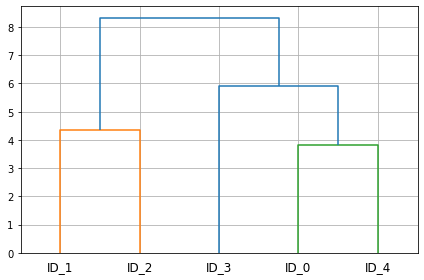

In [61]:
row_dendr = dendrogram(row_clusters, labels=labels)
plt.tight_layout()
plt.ylabel=('Euclidean dsitance')
plt.grid()
#plt.show()

## explore search results contents

In [164]:
search_url_works=io.fmt_jobsrch_url('python', '12345')
search_url_works

'https://www.indeed.com/jobs?q=python&l=12345'

In [143]:
js_resp = requests.get(search_url_works)
js_resp.status_code

200

In [146]:
js_soup = BeautifulSoup(js_resp.content, parser='lxml')
js_soup2 = i.clean_soup(js_soup)

In [189]:
len(str(js_soup))

589738

In [195]:
with open('srch.html','w', encoding='utf8') as f:
    f.write(js_soup.prettify())

In [233]:
s = "'match this'"
print(s)
re.search(r"(?=^\')\S+", s)

'match this'


<re.Match object; span=(0, 6), match="'match">

In [455]:
io = i.indweb()

AttributeError: module 'indjobs' has no attribute 'indweb'

In [17]:
loc, keywords = tuple(pd.read_sql('select * from vars', sldb).loc[0, ['location', 'keywords']])

In [372]:
resp = io.get_jobsrch_page(loc = loc, keywords=keywords)

https://www.indeed.com/jobs?q=python&l=xxxxx&radius=5


In [384]:
links = io.get_joblinks_from_html()
linksl = pd.Series([m.group() for m in links ])

In [394]:
for i in range(len(linksl)):
    if linksl.str.contains(linksl[i], re.I).any():
        print(f"{i} is duplicated")

In [404]:
linksl.name = 'urlpart'#.
linksl
linksl.to_frame().to_sql('joblinks', sldb, if_exists='append')

In [15]:
#urls on the page use a complete different format
url = "https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CAu63qYmF4ruMsyyhkvi8oPoP2sFN7ueC2iu3o-4MDNmzeq_4XpHC_7JQ4fuLa9s1i0uvUxlWjXX-WXdDOoDry3Yzi0QygmyddZubfWasRAOIzB2NhZ2vWiR6ENP2lCT79u6Nm8Muqu733gt8QPTk2chGiJHGjWNu_KHKUtnDNX9O7nfw-FCtnDJZsEUrlCgimUROBW2JHrCiCxhHdBH3TJ1lLjk6BVVhuigvAjHdzjk0EGRMU8jhvQPM_pomqIrC4Z-zRA8R3sBsoCcQw1mMEqRL8G1q98hgITgVZJnVdDZAZ81fvfHI04vmsB8xKCNexTspin-m74SHCdzjUajHNMOeCtCMTTXZZ_H47vnP2w1sYnj3wJy7H2tT5scNESWnc-aizrSx7sSZmXivWNwtA_igMAksqskwvzVo7yvO-4dhTmsUWzieOn8PtpZj3YqzDorA0VwMchI5CgRMpXgH6jOS1_Lnf46sf0iyz69ATg8dgIaUsyR_F0uhYr5Vh3vbedb487Yu90p_h9ZdmPaDE_-gIkXSsTFfFJT3UdE6FW4xxLIQMBAgDBdVDNUnNWk2K6qWwWddec5cGsXftz_Zi9wJfBhG-ltjQFqykp_EDy_glbDKpvdpCHULhWm2qJNGbnic96I4XxUEs3nYlOTyN&p=0&fvj=0&vjs=3&tk=1fpidue3cu4l6800&jsa=7644&sal=0"
url2="https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CJm4vJz7SDlL3lGccjaB2wU5huGLb-8XfJ0aGDrrd1pG8mLTi2J32p6pgCxb7OlmWzFxuvwZAVyfXliF2wgwwxQwfslnlrEQFuGhMFA4gGP3USg7rM6cTH8g31sXnq4T3V21nY_mfwZ2_wRsRhj4N0wH2M5HBGN4GrZrVsL8G3A2HzGc2b7vS60P63L809RENfeZHsgcZjMoUDjhPh53_YfMwVMlbbFgHM1fLM1MrFFSqqVRnJmZBQUd0liELcRcwFDtfUJZa4C6VgJxrQWygAwk9ge-1NUnvfgttgcdVkKWzaIxBXvOHk3aTytD7iBIgQu0Z-NMQ3kkEDPSR8G5UCMhb2EESrp_nPVYeg7uJ1A42RTbyReDG6E3A8T2UTBWxIruFfD0eERoG9GRrouPgSMnbKDWa86p4TYDqhDVHpAVV3u8-MifGIIC1BlgknGZj_X1h-4ZZJ4lr1JGfUfB-Fs64LgrcaFZEc5d66LvHXVdrPmuqxWyr_YbNrJLzaOII5vkzs7AoSp7CUyO-w_MMuye7yr0aOiOI=&p=1&fvj=0&vjs=3&tk=1fpidue3cu4l6800&jsa=7644"
url3="https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AWo9FdwxMInTQwvn1FUqjZdaNIADc6zIPOvXcnk7S6Dk8RJr6Jq6Kb1p8iy7RlZKsXbTWwN6d7V0A5BRIDhbSm3Kobn9gz7rJoZpvPIAKElYbNPf62wwp8cpTqLkeM-nsNenn5xEVwPLAs-Mbn5XMc5HL7kqR38YQGESAQ-F33e1iVtZvaBdWpy2JXfGLSxLHFWQxwH0Dg3Y2Ffs4aDmZxW7j04eKWcIC5T4v9sY43QHP9m04nvSwhgnSPVpb726J38nsXgKf8tGkeR_KqsZ2htDXC9zg_h49tKZ9JCvTJg1czfbibFXw7n6m-69wwI0kZ7GunQQahBPtPJNEZ0pnDoPoXNDWheDCk3agVBdDGeJdKR2IL5xJsZEwPDg6P1X5jlnUeoY-mhnIMJycTJuYGjJ6BI-txuedEFLuyloa7NAXG2sQt_-zJ506uhL12i_kVKt0XjUqPI7-5ZcmHZnmpEbI00uMX5lyy1Ci1nsXb7bbac7POe87EYIS0jra_JSQlMxdC2BlZB3PO8KcjZqYE&from=mobhp_jobfeed&tk=1fpifru7gt6dg801&jsa=3008&vjs=3"
indweb.parse_url_params(url3)

('https://www.indeed.com/pagead/clk',
 {'mo': 'r',
  'ad': '-6NYlbfkN0AWo9FdwxMInTQwvn1FUqjZdaNIADc6zIPOvXcnk7S6Dk8RJr6Jq6Kb1p8iy7RlZKsXbTWwN6d7V0A5BRIDhbSm3Kobn9gz7rJoZpvPIAKElYbNPf62wwp8cpTqLkeM-nsNenn5xEVwPLAs-Mbn5XMc5HL7kqR38YQGESAQ-F33e1iVtZvaBdWpy2JXfGLSxLHFWQxwH0Dg3Y2Ffs4aDmZxW7j04eKWcIC5T4v9sY43QHP9m04nvSwhgnSPVpb726J38nsXgKf8tGkeR_KqsZ2htDXC9zg_h49tKZ9JCvTJg1czfbibFXw7n6m-69wwI0kZ7GunQQahBPtPJNEZ0pnDoPoXNDWheDCk3agVBdDGeJdKR2IL5xJsZEwPDg6P1X5jlnUeoY-mhnIMJycTJuYGjJ6BI-txuedEFLuyloa7NAXG2sQt_-zJ506uhL12i_kVKt0XjUqPI7-5ZcmHZnmpEbI00uMX5lyy1Ci1nsXb7bbac7POe87EYIS0jra_JSQlMxdC2BlZB3PO8KcjZqYE',
  'from': 'mobhp_jobfeed',
  'tk': '1fpifru7gt6dg801',
  'jsa': '3008',
  'vjs': '3'})

## exploring a job detail page

In [400]:
#need to get job descriptions for all of the urls
linkdf = pd.read_sql('select * from joblinks', sldb)
linkdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    15 non-null     int64 
 1   urlpart  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 368.0+ bytes


In [447]:


sj_jks =saved_jobs['jk'].apply(get_url_jk_part)
sj_jks.drop_duplicates()

index
0     f3893204eefa920f
2     7c08233325d9e386
3     88388887b8ea43b8
4     43b094952df12544
5     bab038b5bda6d11a
38    e3f7000feda6bf6e
39    886c10571b6df72a
40    394861779252a761
41    82d39753e9681072
42    e2cec6af99f18fe3
43    9dc4e1427e2e3c0d
44    a2177374e9a06968
45    23f5d0572cff0630
46    1b86e4014046a7b5
47    f97cf563e9fcdcb0
Name: jk, dtype: object

In [448]:
linkdf = linkdf[~ linkdf['urlpart'].apply(get_url_jk_part).isin(sj_jks)]

In [449]:
print(len(linkdf))
linkdf

4


,index,urlpart
11,11,"""/m/basecamp/viewjob?viewtype=embedded&jk=28b3..."
12,12,"""/m/basecamp/viewjob?viewtype=embedded&jk=1455..."
13,13,"""/m/basecamp/viewjob?viewtype=embedded&jk=222b..."
14,14,"""/m/basecamp/viewjob?viewtype=embedded&jk=565e..."


In [450]:
from time import sleep
for l in linkdf['urlpart'].unique():
    print(f"processing {l} ... ", end="")
    df = process_jobdet_url(l)
    if isinstance(df, pd.DataFrame):
        df.to_sql('job_postings',  sldb, if_exists='append',index=False,)
    print("done")
    sleep(5)
print('all done')

processing "/m/basecamp/viewjob?viewtype=embedded&jk=28b3df2fbe622503&from=vjs&tk=1fpiuu0iqt53e800"}, ... url for job detail is https://www.indeed.com/viewjob?jk=28b3df2fbe622503
done
processing "/m/basecamp/viewjob?viewtype=embedded&jk=145595560b765722&from=vjs&tk=1fpiuu0iqt53e800"}, ... url for job detail is https://www.indeed.com/viewjob?jk=145595560b765722
done
processing "/m/basecamp/viewjob?viewtype=embedded&jk=222b1413ecdb8601&from=vjs&tk=1fpiuu0iqt53e800"}, ... url for job detail is https://www.indeed.com/viewjob?jk=222b1413ecdb8601
done
processing "/m/basecamp/viewjob?viewtype=embedded&jk=565efda3b7064523&from=vjs&tk=1fpiuu0iqt53e800"}] ... url for job detail is https://www.indeed.com/viewjob?jk=565efda3b7064523
done
all done


In [289]:
#traceback.print_tb(sys.last_traceback)
#sys.exc_info()

In [453]:
saved_jobs = pd.read_sql('select * from job_postings', sldb).set_index('index')
saved_jobs

,title,company,description,address,jk
index,,,,,
0,Cloud Engineering Associate - Summer/Fall 2022,"PRICE WATERHOUSE COOPERS\n7,832 reviews\nAlban...",Job details\nJob Type\nSeasonal\nFull Job Desc...,\n,jk=f3893204eefa920f
1,Cloud Engineering Associate - Summer/Fall 2022,"PRICE WATERHOUSE COOPERS\n7,832 reviews\nAlban...",Job details\nJob Type\nSeasonal\nFull Job Desc...,\n,https://www.indeed.com/viewjob?jk=f3893204eefa...
2,Data Analyst (Lead),"Verizon\n29,378 reviews\n64 Mountain Blvd, Tow...",When you join Verizon\nVerizon is one of the w...,\n,https://www.indeed.com/viewjob?jk=7c08233325d9...
3,1628 Data Scientist,"Infoorigin inc\nTrenton, NJ","Job details\nSalary\n$82,974 - $218,909 a year...",\n,https://www.indeed.com/viewjob?jk=88388887b8ea...
4,Sr. Analyst - (Real World Evidence Machine Lea...,"Kelly\n16,473 reviews\nSkillman, NJ 08558\nRemote",Job details\nJob Type\nTemporary\nContract\nFu...,\n,https://www.indeed.com/viewjob?jk=43b094952df1...
38,Data Quality Engineer,"Datto Jobs\nEast Greenbush, NY",As the world's leading provider of cloud-based...,\n,https://www.indeed.com/viewjob?jk=e3f7000feda6...
39,Spring 2022 Paid Placement for Graduate & Unde...,New York State Office of the Attorney General\...,Job details\nJob Type\nPart-time\nFull Job Des...,\n,https://www.indeed.com/viewjob?jk=886c10571b6d...
40,Security Automation Engineer,"S&P Global\n1,368 reviews\nAlbany, NY 12201","Job details\nSalary\n$68,300 - $155,900 a year...",\n,https://www.indeed.com/viewjob?jk=394861779252...
41,Part Time Computer Science Tutor -- Remote,"Pearson\n2,706 reviews\n1365 Washington Ave, A...",Job details\nSalary\n$16 an hour\nJob Type\nPa...,\n,https://www.indeed.com/viewjob?jk=82d39753e968...


In [454]:
saved_jobs['jk'].value_counts()

https://www.indeed.com/viewjob?jk=565efda3b7064523    1
https://www.indeed.com/viewjob?jk=88388887b8ea43b8    1
https://www.indeed.com/viewjob?jk=28b3df2fbe622503    1
https://www.indeed.com/viewjob?jk=e3f7000feda6bf6e    1
https://www.indeed.com/viewjob?jk=145595560b765722    1
https://www.indeed.com/viewjob?jk=f97cf563e9fcdcb0    1
https://www.indeed.com/viewjob?jk=222b1413ecdb8601    1
https://www.indeed.com/viewjob?jk=23f5d0572cff0630    1
https://www.indeed.com/viewjob?jk=f3893204eefa920f    1
https://www.indeed.com/viewjob?jk=394861779252a761    1
https://www.indeed.com/viewjob?jk=9dc4e1427e2e3c0d    1
https://www.indeed.com/viewjob?jk=e2cec6af99f18fe3    1
https://www.indeed.com/viewjob?jk=a2177374e9a06968    1
https://www.indeed.com/viewjob?jk=7c08233325d9e386    1
https://www.indeed.com/viewjob?jk=1b86e4014046a7b5    1
https://www.indeed.com/viewjob?jk=43b094952df12544    1
https://www.indeed.com/viewjob?jk=886c10571b6df72a    1
https://www.indeed.com/viewjob?jk=82d39753e96810

### timestamp conversion
ts param in urls

In [6]:
ts = 1636682493568#1636493555554
# moved convert_indeed_ts to indded_jobs module

i.convert_indeed_ts(ts).strftime('%x %X')

'11/11/21 21:01:33'

In [57]:
def dontrun():
    #things to clean up but keeping for now in case the syntax is needed
    l = list()
    for e in a:
        try:
            l.append(e.attrs['class'])
        except:
            l.append(['no class'])
    Counter(tuple(mi.flatten(l))).most_common()

    pd.DataFrame([e.attrs for e in a])

    rx = re.compile(r'(?:\")[\w/]*?viewjob\?[\w=&]+(?P<jk>jk=\w+)[\w=&-]+.{1,3}',re.IGNORECASE|re.UNICODE)
    #rx = re.compile(r'"\".*?viewjob\?[\w=&]+(?P<jk>jk=\w+)[\w=&-]+',re.IGNORECASE|re.UNICODE)
    #rx = re.compile(r'(?:\")[\w/]+viewjob\?',re.IGNORECASE|re.UNICODE)
    m = rx.search(js_resp.content.decode())
    print(m.group())
    print(m.groups()[0])

    i = rx.finditer(str(js_soup))
    #pass a start param to get the next page of results
    #results are usually shown 10 per page
    #first and last jobcards seem to ahve dupe link entries with some additional params
    links = [m.group() for m in i]
    len(links), links

    def tag_attributes_as_df():
        linkdf = pd.DataFrame([x.attrs for x in js_soup2.find_all('a')])#['href'].sample(10)
        linkdf.sample(10)

    linkdf2=linkdf.dropna(subset=['href'])
    linkdf2.sample(10)

    linkdf2[linkdf2['href'].str.contains('job')]['href'].drop_duplicates().values

    ## is there anything of value in the metadata?
    # yes, but so hard to extract it
    rx = re.compile('.{,100}viewjob\?[\w=&]+(?P<jk>jk=\w+)[\w=&-]+.{1,3}', re.I)
    m = rx.search(str(res))
    matchlocals = ['end', 'endpos', 'expand', 'group', 'groupdict', 'groups', 'lastgroup', 'lastindex', 'pos', 're', 'regs', 'span', 'start', 'string']
    if m is not None:
        print(m.start(), m.end(), m.pos, m.endpos, m.regs, m.group(), m.groups(), m.span())

    #fields of value: snippet, truncatedCompany, viewJobLink

    m.string[m.regs[0][0]:m.regs[0][1]]

    lines = js_soup.prettify().splitlines()
    res = [l for l in lines if rx.search(l)]
    sres = str(res)
    meta = sres[sres.index('=')+1:]
    bigstring = unquote(meta).replace('\\\\"','"')#.replace('true','True').replace('false','False')
    #json.loads(bigstring)#fails
    #exec(bigstring) #not python dict either


    len(bigstring)

    link = "https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CAu63qYmF4ruMsyyhkvi8oPoP2sFN7ueC2iu3o-4MDNmzeq_4XpHC_7JQ4fuLa9s1i0uvUxlWjXX-WXdDOoDry3Yzi0QygmyddZubfWasRAOIzB2NhZ2vWiR6ENP2lCT79u6Nm8Muqu733gt8QPTk2chGiJHGjWNu_KHKUtnDNX9O7nfw-FCtnDJZsEUrlCgimUROBW2JHrCiCxhHdBH3TJ1lLjk6BVVhuigvAjHdzjk0EGRMU8jhvQPM_pomqIrC4Z-zRA8R3sBsoCcQw1mMEqRL8G1q98hgITgVZJnVdDZAZ81fvfHI04vmsB8xKCNexTspin-m74SHCdzjUajHNMOeCtCMTTXZZ_H47vnP2w1sYnj3wJy7H2tT5scNESWnc-aizrSx7sSZmXivWNwtA_igMAksqskwvzVo7yvO-4dhTmsUWzieOn8PtpZj3YqzDorA0VwMchI5CgRMpXgH6jOS1_Lnf46sf0iyz69ATg8dgIaUsyR_F0uhYr5Vh3vbedb487Yu90p_h9ZdmPaDE_-gIkXSsTFfFJT3UdE6FW4xxLIQMBAgDBdVDNUnNWk2K6qWwWddec5cGsXftz_Zi9wJfBhG-ltjQFqykp_EDy_glbDKpvdpCHULhWm2qJNGbnic96I4XxUEs3nYlOTyN&p=0&fvj=0&vjs=3&tk=1fpidue3cu4l6800&jsa=7644"
    unquote(link)

    bigstring[951:971+200]

    ### get data out of the link text in the jobcard instead - the whole jobcards is a link

    lookfor_ex = """<a id="job_a2184ec016dee29e" data-mobtk="1fkocfvtru31j801" data-jk="a2184ec016dee29e" data-hiring-event="false" rel="nofollow" data-hide-spinner="true" class="tapItem fs-unmask result job_a2184ec016dee29e resultWithShelf sponTapItem desktop vjs-highlight" href="/company/Talentheed-Inc/jobs/Data-Analyst-a2184ec016dee29e?fccid=c74998f9af9be394&amp;vjs=3" target="_blank">
    """
    lookfor_ex

    s2 = i.clean_soup(js_soup)

    def attrs_as_df_again():
        linkdf = pd.DataFrame([x.attrs for x in s2.find_all('a')])
        linkdf[linkdf['id'].str.contains('job_').fillna(False)]

    print(s2.find('body').prettify())

    pd.DataFrame([x.attrs for x  in s2.find('body').find_all('table')])

[('icl-GlobalFooter-link', 18),
 ('emf9s7v0', 7),
 ('gnav-header-1999525', 5),
 ('jobsearch-RelatedLinks-link', 3),
 ('no class', 2),
 ('icl-Button', 2),
 ('gnav-Logo', 1),
 ('gnav-header-8l0s9d', 1),
 ('gnav-header-zq9pue', 1),
 ('gnav-header-1v8slhd', 1),
 ('e8ju0x51', 1),
 ('icl-WhatWhere-advSearchLink', 1),
 ('icl-Ratings-starsCountWrapper', 1),
 ('icl-Ratings-link', 1),
 ('icl-NavigableContainer-linkWrapper', 1),
 ('icl-Button--secondary', 1),
 ('icl-Button--sm', 1),
 ('icl-Button--primary', 1),
 ('icl-Button--md', 1)]

In [23]:
for x in s2.find('body').find_all('table'):
    for c in x.attrs['class']:
        if 'jobCard' in c:
            print(x.contents,"\n***\n")

[<tbody><tr><td class="resultContent"><h2 class="jobTitle jobTitle-color-purple">Director of Financial Planning and Analysis</h2><pre><a class="turnstileLink companyOverviewLink" data-tn-element="companyName" href="/cmp/Ferraro-Foods" rel="noopener" target="_blank">Ferraro Foods</a><a aria-label="Company rating 2.7 out of 5 stars" class="ratingLink" data-tn-variant="cmplinktst2" href="/cmp/Ferraro-Foods/reviews" rel="noopener" target="_blank" title="Ferraro Foods reviews">2.7</a>Piscataway, NJ<!-- --> <!-- -->08854</pre></td></tr></tbody>] 
***

[<tbody><tr class="jobCardShelf"><td class="shelfItem indeedApply">Easily apply</td></tr><tr class="underShelfFooter"><td><ul style="list-style-type:circle;margin-top: 0px;margin-bottom: 0px;padding-left:20px;">
<li>The position of Director of Financial Planning and <b>Analysis</b> is exempt from the overtime provisions of the Federal Fair Labor Standards Act and shall not be…</li>
</ul>Active 3 days ago</td></tr></tbody>] 
***

[<tbody><tr><td

In [2]:
tm = s2.find_all('table',attrs={'class':'jobCard_mainContent'})

NameError: name 's2' is not defined

In [3]:
e = tm[0]

NameError: name 'tm' is not defined

In [1]:
e

NameError: name 'e' is not defined

In [49]:
e.name, e.attrs

('table',
 {'cellpadding': '0',
  'cellspacing': '0',
  'class': ['jobCard_mainContent', 'big6_visualChanges'],
  'role': 'presentation'})

In [46]:
e.next_element()#[0].name

[<tr><td class="resultContent"><h2 class="jobTitle jobTitle-color-purple">Director of Financial Planning and Analysis</h2><pre><a class="turnstileLink companyOverviewLink" data-tn-element="companyName" href="/cmp/Ferraro-Foods" rel="noopener" target="_blank">Ferraro Foods</a><a aria-label="Company rating 2.7 out of 5 stars" class="ratingLink" data-tn-variant="cmplinktst2" href="/cmp/Ferraro-Foods/reviews" rel="noopener" target="_blank" title="Ferraro Foods reviews">2.7</a>Piscataway, NJ<!-- --> <!-- -->08854</pre></td></tr>,
 <td class="resultContent"><h2 class="jobTitle jobTitle-color-purple">Director of Financial Planning and Analysis</h2><pre><a class="turnstileLink companyOverviewLink" data-tn-element="companyName" href="/cmp/Ferraro-Foods" rel="noopener" target="_blank">Ferraro Foods</a><a aria-label="Company rating 2.7 out of 5 stars" class="ratingLink" data-tn-variant="cmplinktst2" href="/cmp/Ferraro-Foods/reviews" rel="noopener" target="_blank" title="Ferraro Foods reviews">2.7

In [55]:
s = e.next_sibling()[0].parent
s, s.attrs

(<table class="jobCardShelfContainer big6_visualChanges" role="presentation"><tbody><tr class="jobCardShelf"><td class="shelfItem indeedApply">Easily apply</td></tr><tr class="underShelfFooter"><td><ul style="list-style-type:circle;margin-top: 0px;margin-bottom: 0px;padding-left:20px;">
 <li>The position of Director of Financial Planning and <b>Analysis</b> is exempt from the overtime provisions of the Federal Fair Labor Standards Act and shall not be…</li>
 </ul>Active 3 days ago</td></tr></tbody></table>,
 {'class': ['jobCardShelfContainer', 'big6_visualChanges'],
  'role': 'presentation'})

In [60]:
[(x.name,x.getText()) for x in e.find_all()]

[('tbody',
  'Director of Financial Planning and AnalysisFerraro Foods2.7Piscataway, NJ 08854'),
 ('tr',
  'Director of Financial Planning and AnalysisFerraro Foods2.7Piscataway, NJ 08854'),
 ('td',
  'Director of Financial Planning and AnalysisFerraro Foods2.7Piscataway, NJ 08854'),
 ('h2', 'Director of Financial Planning and Analysis'),
 ('pre', 'Ferraro Foods2.7Piscataway, NJ 08854'),
 ('a', 'Ferraro Foods'),
 ('a', '2.7')]

In [62]:
x

<table class="jobCardShelfContainer big6_visualChanges" role="presentation"><tbody><tr class="jobCardShelf"><td class="shelfItem indeedApply">Easily apply</td></tr><tr class="underShelfFooter"><td><ul style="list-style-type:circle;margin-top: 0px;margin-bottom: 0px;padding-left:20px;">
<li>Condor Capital Wealth Management, a fee-only registered investment advisor recently named one of the best places to work in NJ, is seeking an entry-level…</li>
</ul>1 day ago·<ul><li>View all <a href="/q-Condor-Capital-Management-l-Martinsville,-NJ-jobs.html">Condor Capital Management jobs in Martinsville, NJ</a> - <a href="/l-Martinsville,-NJ-jobs.html">Martinsville jobs</a></li><li>Salary Search: <a href="/career/financial-analyst/salaries/08836--NJ?campaignid=serp-more&amp;fromjk=bfb8a568523f51da&amp;from=serp-more">Financial Analyst/Trader salaries in Martinsville, NJ</a></li></ul></td></tr></tbody></table>

In [63]:
l2 = "https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0ADTliTSg4K3aDxe8vkHVVj5ml6bx8ND6Ab8oliGx3AtQak9O875La2bFZ7Jqdg5u11Jk7rtQt7sHG-h09JeizLnCFgpka8ASF6M6Ns7V402eW9sjD4wqrOonQX3fjpNfXoNj_bENFV2MC2Sl5ZIYgCks99e4bPYy_3v8aNsi9jcTczsfk8JvrAoGXmnQ_-Fu7WBk_Z7g2WIhfLaYs_ufNIcdyRqL_coU2UPcSB3lU6sl2j7z6Gnhe7-nuhXDLjZL80a-5Nk3r0RO8RF95zHUUuAMH1qpMZs1Frap27GCCw7ThY-4xojmOV98LS8omwJV1RHDVxuFx2Xfc9HVBIKfW1BJvbzngwZV7hGFO6hwC2xU-rJmT5GZ17gob6J9oLQbGgQ8Pv92VfkYCI82t9QmUvvN-PDFlGXYxF3cj-PiKZLfDHkZjkRD4SZJmxDRR3EQ3ilNZtAbkPm1kvYwszVtiv879tPyDLD_M=&p=1&fvj=0&vjs=3&tk=1fkebcfhu3ojk000&jsa=5310&sal=1"
print(unquote(l2))

https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0ADTliTSg4K3aDxe8vkHVVj5ml6bx8ND6Ab8oliGx3AtQak9O875La2bFZ7Jqdg5u11Jk7rtQt7sHG-h09JeizLnCFgpka8ASF6M6Ns7V402eW9sjD4wqrOonQX3fjpNfXoNj_bENFV2MC2Sl5ZIYgCks99e4bPYy_3v8aNsi9jcTczsfk8JvrAoGXmnQ_-Fu7WBk_Z7g2WIhfLaYs_ufNIcdyRqL_coU2UPcSB3lU6sl2j7z6Gnhe7-nuhXDLjZL80a-5Nk3r0RO8RF95zHUUuAMH1qpMZs1Frap27GCCw7ThY-4xojmOV98LS8omwJV1RHDVxuFx2Xfc9HVBIKfW1BJvbzngwZV7hGFO6hwC2xU-rJmT5GZ17gob6J9oLQbGgQ8Pv92VfkYCI82t9QmUvvN-PDFlGXYxF3cj-PiKZLfDHkZjkRD4SZJmxDRR3EQ3ilNZtAbkPm1kvYwszVtiv879tPyDLD_M=&p=1&fvj=0&vjs=3&tk=1fkebcfhu3ojk000&jsa=5310&sal=1


In [73]:
e

<table cellpadding="0" cellspacing="0" class="jobCard_mainContent big6_visualChanges" role="presentation"><tbody><tr><td class="resultContent"><h2 class="jobTitle jobTitle-color-purple">Director of Financial Planning and Analysis</h2><pre><a class="turnstileLink companyOverviewLink" data-tn-element="companyName" href="/cmp/Ferraro-Foods" rel="noopener" target="_blank">Ferraro Foods</a><a aria-label="Company rating 2.7 out of 5 stars" class="ratingLink" data-tn-variant="cmplinktst2" href="/cmp/Ferraro-Foods/reviews" rel="noopener" target="_blank" title="Ferraro Foods reviews">2.7</a>Piscataway, NJ<!-- --> <!-- -->08854</pre></td></tr></tbody></table>

# read job descriptions from file

In [1]:
import os

In [11]:
#os.listdir(os.path.expanduser('~\\My Documents'))
#os.path.expandvars('$userprofile\\My Documents') #Permission Error

rootdir = os.path.join(os.environ['public'],'Documents')
rootdir

'C:\\Users\\Public\\Documents'

In [39]:
with open(os.path.join(rootdir, 'job_descs.txt'), 'r', encoding = 'utf8' ) as f:
    alltext = f.read()

In [41]:
docs = alltext.split('---')

In [42]:
#the number of 'documents that were read from the file'
len(docs)

33

In [50]:
all_lens = pd.Series(map(len, docs))
all_lens.max(), all_lens.min(), all_lens.mean()

(7661, 1, 3775.151515151515)

for each document
- tokenize - 
- remove punct
- remove stopwords - built into the countVectorizer (rolled into TfidfVectorizer)
- stem - not very helpful for clustering/classification
    - porter stemmer
- compute tf/idf


In [ ]:
# fit a clustering model
# use silhouette plot to check the clustering - differenc between cluster cohesion and cluster separation
    - cluster cohesion - average distance between a cluster point and all other points in that cluster
    - cluster separation - average disance between the example and all other examples in the nearest cluster
# use ELBOW METHOD to find optimal # of clusters
# distortion (within cluster SSE)
